# Biction price forecasts — based on ARIMA and LSTM model

## 1. Introduction

a. What question are you answering with your project?

b. Why should we care about this question?

covid爆发后，2020年4月全球股市回升，btc价格也随之上涨，迎来btc新阶段
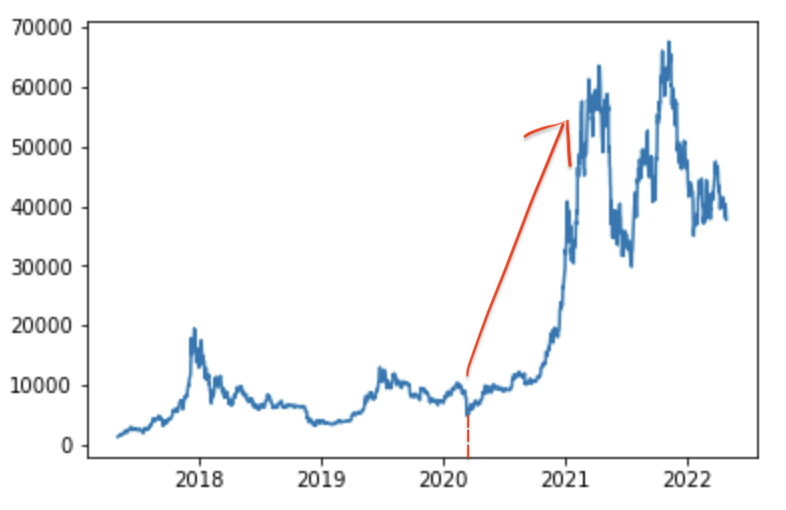

c. Have there been previous papers in the economics literature addressing this question?
Summarize previous research briefly.

## 2. Data

a. Describe the source(s) of the data
b. Discuss whether you are removing any outliers from your data, or doing any other
sampling restrictions
c. Discuss whether you are transforming the data and/or merging/appending multiple
datasets together
d. Show comprehensive summary statistics.
■ Remember: summary statistics are a very important part of all applied work!

## 3. Modeling

In [1]:
def acf_plot(data):
    plot_acf(data)
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('ACF')

def pacf_plot(data):
    if len(data)<=40:
        plot_pacf(data,lags=(len(data)/2-1))
    else:
        plot_pacf(data)
    plt.title('Partial Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    
def searchARMA(data, exog, max_p, max_q):
    
    aic = np.zeros((max_p,max_q))
    bic = np.zeros((max_p,max_q))
    aic_test = 1000000
    p = 0
    q = 0
    for i in range(max_p):
        for j in range(max_q):
            try:
                if len(exog)==len(data):
                    model = ARMA(data,(i,j),exog=exog)
                else:
                    model = ARMA(data,(i,j))
                res = model.fit(disp=0,trend='nc')
                aic[i,j] = res.aic
                if aic_test>aic[i,j]:
                    aic_test=aic[i,j]
                    p=i
                    q=j
                bic[i,j] = res.bic
                print('p:',i,' q:', j,' aic:', aic[i,j], ' bic:', bic[i,j])
            except:
                continue
    print(p,q)
    
def get_forecast(ARMA_res,log):

    l = len(test)
    start_index = length
    end_index = start_index + l
    f = ARMA_res.predict(start=start_index, end=end_index)
    if log == False:
        forecast = test[0]
        F = [forecast]
        for i in range(1,l):
            forecast = forecast + f[i]
            F.append(forecast)
            i = i+1
    else:
        forecast = np.log(test[0])
        F = [forecast]
        for i in range(1,l):
            forecast = forecast + f[i]
            F.append(forecast)
            i = i+1
            
    return F

def plot_diagnostics(data):
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
    ax1.hist(data, bins = 40, color = 'm', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth = 5)
    ax1.grid()
    ax1.set_title("Hist Resid")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Resid")
    
    fig = plot_acf(data,lags=40,zero=False,ax=ax3,use_vlines=True)
    ax3.grid()
    
    fig = sm.qqplot(data, line='q', ax = ax4)
    ax4.grid()
    
    plt.tight_layout()
    
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA, ARMA
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import datetime
from datetime import datetime, timedelta
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [3]:
BTC = yf.download('BTC-USD', start='2020-04-30', end='2022-04-30')

[*********************100%***********************]  1 of 1 completed


In [4]:
BTC[:5]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-30,8797.669922,9440.650391,8533.255859,8658.553711,8658.553711,66964629541
2020-05-01,8672.782227,9048.023438,8667.763672,8864.766602,8864.766602,44068389997
2020-05-02,8869.057617,9007.187500,8811.366211,8988.596680,8988.596680,40134388683
2020-05-03,8983.614258,9167.781250,8830.971680,8897.468750,8897.468750,47101785174
2020-05-04,8895.745117,8956.906250,8645.024414,8912.654297,8912.654297,45718796276


In [5]:
BTC_close = np.array(BTC['Close'])
BTC_close.shape

(731,)

## ARIMA model (including first_order difference and log first_order difference)

Text(0, 0.5, 'Close Price USD ($)')

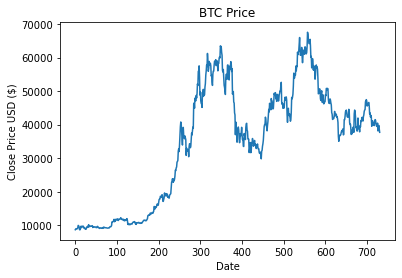

In [6]:
plt.plot(BTC_close)
plt.title('BTC Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

Text(0, 0.5, 'Close Price USD ($)')

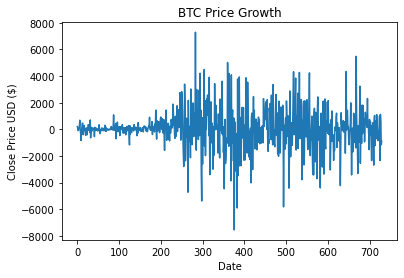

In [7]:
BTC_diff = BTC_close[1:] - BTC_close[:-1]
plt.plot(BTC_diff)
plt.title('BTC Price Growth')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

Text(0, 0.5, 'Close Price USD ($)')

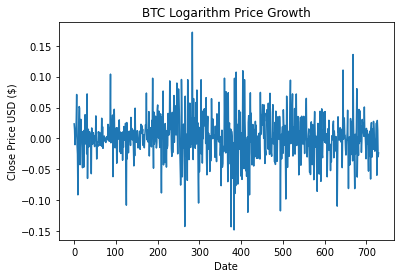

In [8]:
BTC_log = np.log(BTC_close)
BTC_log_diff1 = BTC_log[1:] - BTC_log[:-1]
plt.plot(BTC_log_diff1)
plt.title('BTC Logarithm Price Growth')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

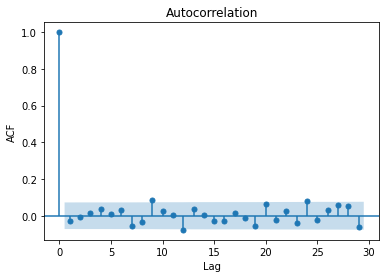

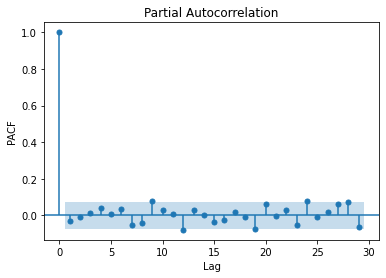

In [9]:
acf_plot(BTC_diff)
pacf_plot(BTC_diff)

In [10]:
length = int(np.ceil( len(BTC_close)* .9))
train = BTC_close[0:length]
test = BTC_close[length:]
BTC_diff = train[1:] - train[:-1]
BTC_log = np.log(train)
BTC_log_diff = BTC_log[1:] - BTC_log[:-1]

In [11]:
result1 = adfuller(train)
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
for key, value in result1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.425670
p-value: 0.569910
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [12]:
result2 = adfuller(BTC_diff)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.368992
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [13]:
result3 = adfuller(BTC_log)
print('ADF Statistic: %f' % result3[0])
print('p-value: %f' % result3[1])
for key, value in result3[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.566069
p-value: 0.500612
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [14]:
result4 = adfuller(BTC_log_diff)
print('ADF Statistic: %f' % result4[0])
print('p-value: %f' % result4[1])
for key, value in result4[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.350684
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [15]:
n_BTC_diff = len(BTC_diff)
exog_BTC_diff = np.ones(n_BTC_diff)
searchARMA(BTC_diff, exog_BTC_diff, max_p=5, max_q=5)

p: 0  q: 0  aic: 11461.04555903225  bic: 11470.02092706922
p: 0  q: 1  aic: 11462.427075619094  bic: 11475.89012767455
p: 0  q: 2  aic: 11464.420978611135  bic: 11482.371714685074
p: 0  q: 3  aic: 11466.28313214072  bic: 11488.721552233143
p: 0  q: 4  aic: 11466.168699100735  bic: 11493.094803211643
p: 1  q: 0  aic: 11462.424258648192  bic: 11475.887310703647
p: 1  q: 1  aic: 11464.423478097226  bic: 11482.374214171165
p: 1  q: 2  aic: 11465.710367463978  bic: 11488.148787556402
p: 1  q: 3  aic: 11467.311021330112  bic: 11494.237125441019
p: 1  q: 4  aic: 11468.148022956857  bic: 11499.561811086249
p: 2  q: 0  aic: 11464.422961752936  bic: 11482.373697826875
p: 2  q: 1  aic: 11465.685700518976  bic: 11488.1241206114
p: 2  q: 2  aic: 11457.135985076804  bic: 11484.062089187712
p: 2  q: 3  aic: 11456.497805874802  bic: 11487.911594004194
p: 2  q: 4  aic: 11469.980321233697  bic: 11505.881793381574
p: 3  q: 0  aic: 11466.334276952055  bic: 11488.772697044478
p: 3  q: 1  aic: 11467.3960874

In [16]:
model_BTC_diff = ARIMA(BTC_diff,order=(2,0,3))
ARMA_res_1 = model_BTC_diff.fit(disp=0)
print(ARMA_res_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  657
Model:                     ARMA(2, 3)   Log Likelihood               -5721.249
Method:                       css-mle   S.D. of innovations           1463.656
Date:                Wed, 04 May 2022   AIC                          11456.498
Time:                        02:14:41   BIC                          11487.912
Sample:                             0   HQIC                         11468.676
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.6729     57.212      0.938      0.348     -58.461     165.807
ar.L1.y       -0.4811      0.021    -22.722      0.000      -0.523      -0.440
ar.L2.y       -0.9573      0.027    -35.805      0.0

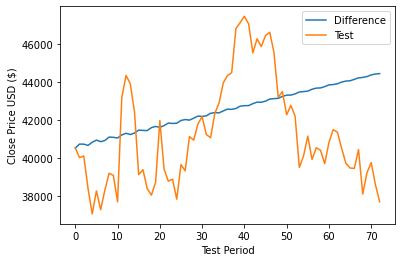

In [17]:
F1 = get_forecast(ARMA_res_1,log=False)
plt.plot(F1)
plt.plot(test)
plt.xlabel('Test Period')
plt.ylabel('Close Price USD ($)')
plt.legend(['Difference','Test'])

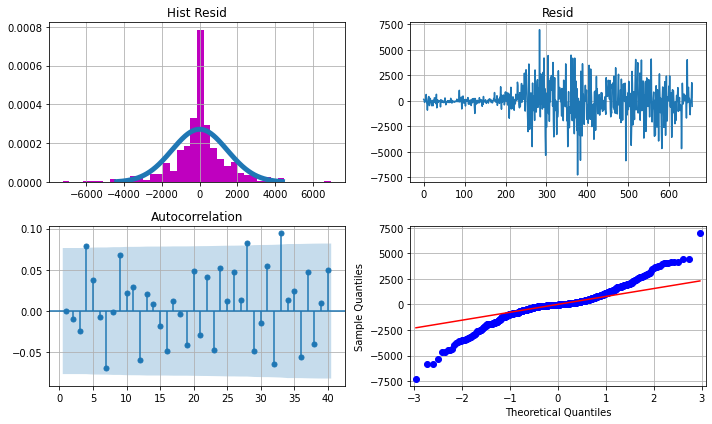

In [18]:
resid_BTC_diff = ARMA_res_1.resid
plot_diagnostics(resid_BTC_diff)

### Log

In [19]:
n_BTC_log_diff = len(BTC_log_diff)
exog_BTC_log_diff = np.ones(n_BTC_log_diff)
searchARMA(BTC_log_diff, exog_BTC_log_diff, max_p=5, max_q=5)

p: 0  q: 0  aic: -2474.5713563911127  bic: -2465.5959883541436
p: 0  q: 1  aic: -2473.153880298363  bic: -2459.6908282429094
p: 0  q: 2  aic: -2471.1556586808665  bic: -2453.204922606928
p: 0  q: 3  aic: -2469.1690745533733  bic: -2446.73065446095
p: 0  q: 4  aic: -2469.1246437915306  bic: -2442.198539680623
p: 1  q: 0  aic: -2473.155535576784  bic: -2459.6924835213304
p: 1  q: 1  aic: -2471.2974438703004  bic: -2453.346707796362
p: 1  q: 2  aic: -2471.0774951614085  bic: -2448.639075068985
p: 1  q: 3  aic: -2469.2213867992623  bic: -2442.2952826883547
p: 1  q: 4  aic: -2467.405512144471  bic: -2435.9917240150785
p: 2  q: 0  aic: -2471.1564162494187  bic: -2453.20568017548
p: 2  q: 1  aic: -2469.323390625281  bic: -2446.8849705328576
p: 2  q: 2  aic: -2467.3470482620432  bic: -2440.4209441511357
p: 2  q: 3  aic: -2471.1223614309165  bic: -2439.708573301524
p: 2  q: 4  aic: -2465.9578818660666  bic: -2430.0564097181896
p: 3  q: 0  aic: -2469.193712132329  bic: -2446.7552920399057
p: 3  

In [20]:
model_BTC_log_diff = ARIMA(BTC_log_diff,order=(0,0,0))
ARMA_res_2 = model_BTC_log_diff.fit(disp=0)
print(ARMA_res_2.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  657
Model:                     ARMA(0, 0)   Log Likelihood                1239.286
Method:                           css   S.D. of innovations              0.037
Date:                Wed, 04 May 2022   AIC                          -2474.571
Time:                        02:14:57   BIC                          -2465.596
Sample:                             0   HQIC                         -2471.092
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.728      0.084      -0.000       0.005


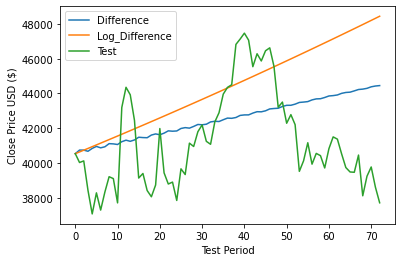

In [21]:
F2 = get_forecast(ARMA_res_2,log=True)
F2 = np.exp(F2)
plt.plot(F1)
plt.plot(F2)
plt.plot(test)
plt.xlabel('Test Period')
plt.ylabel('Close Price USD ($)')
plt.legend(['Difference','Log_Difference','Test'])

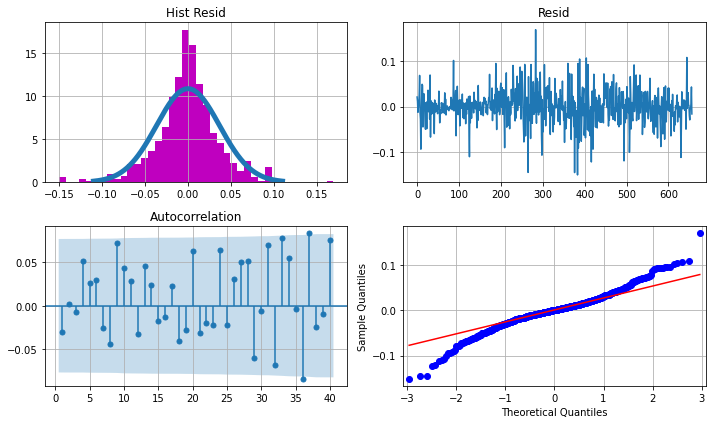

In [22]:
resid_BTC_log_diff = ARMA_res_2.resid
plot_diagnostics(resid_BTC_log_diff)

## LSTM model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
BTC_LSTM = BTC.filter(['Close'])
dataset = BTC_LSTM.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data.shape

(731, 1)

In [24]:
train_data = scaled_data[0:int(length), :]
test_data = scaled_data[int(length)-60: , :]
trainX,trainY=createXY(train_data,60)
testX,testY=createXY(test_data,60)
print(trainX.shape)
print(testX.shape)

(598, 60, 1)
(73, 60, 1)


In [43]:
# Build the LSTM model
BTC_model = Sequential()
BTC_model.add(LSTM(128,return_sequences=True,input_shape=(60,1)))
BTC_model.add(LSTM(64,return_sequences=False))
BTC_model.add(Dense(25))
BTC_model.add(Dense(1))
# Compile the model
BTC_model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
BTC_model.fit(trainX, trainY, batch_size=2, epochs=16)

Epoch 1/16
336/336 [==============================] - 11s 26ms/step - loss: 0.0050
Epoch 2/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0024
Epoch 3/16
336/336 [==============================] - 10s 29ms/step - loss: 0.0020
Epoch 4/16
336/336 [==============================] - 10s 28ms/step - loss: 0.0017
Epoch 5/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0012
Epoch 6/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0014
Epoch 7/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0011
Epoch 8/16
336/336 [==============================] - 9s 26ms/step - loss: 9.9364e-04
Epoch 9/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0011
Epoch 10/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0010
Epoch 11/16
336/336 [==============================] - 9s 27ms/step - loss: 0.0013
Epoch 12/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0014
Epoch 

In [45]:
predictions = BTC_model.predict(testX)
predictions = scaler.inverse_transform(predictions)
train_LSTM = BTC_LSTM[:length+1]
valid_LSTM = BTC[length:]
valid_LSTM['Predictions'] = predictions
valid_ARIMA = BTC[length:]
valid_ARIMA['Difference'] = F1
valid_ARIMA['Log(Difference)'] = F2

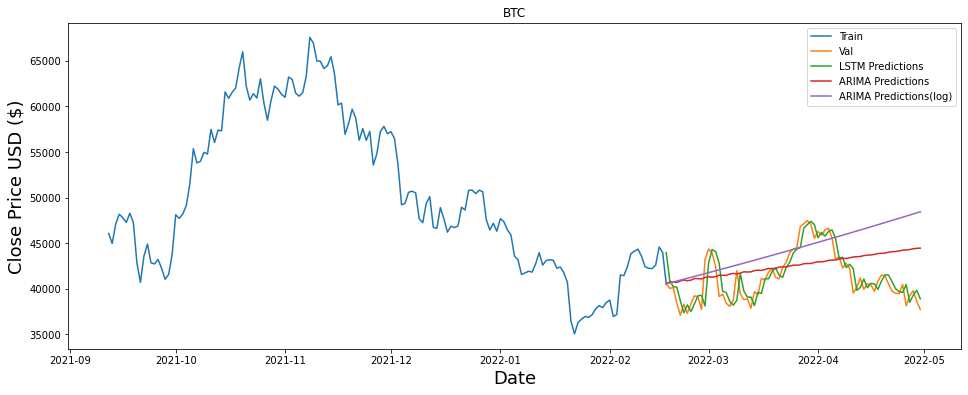

In [46]:
plt.figure(figsize=(16,6))
plt.title('BTC')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_LSTM['Close'][500:])
plt.plot(valid_LSTM[['Close', 'Predictions']])
plt.plot(valid_ARIMA[['Difference', 'Log(Difference)']])
plt.legend(['Train', 'Val', 'LSTM Predictions', 'ARIMA Predictions', 'ARIMA Predictions(log)'], loc='upper right')
plt.show()

## Use models to predict future prices

In [88]:
BTC_60_days_past=BTC.iloc[-60:,:]
last_date = BTC_60_days_past.iloc[[-1]].index
BTC_70_days=BTC_60_days_past

for i in range(10):
    last_date = last_date + timedelta(days=1)
    BTC_70_days= BTC_70_days.append(pd.DataFrame(index=last_date))

BTC_70_days = pd.DataFrame(BTC_70_days['Close'])
BTC_10_days_future = BTC_90_days[-10:]
BTC_60_days_past = pd.DataFrame(BTC_60_days_past['Close'])

old_scaled_array=scaler.transform(BTC_60_days_past)
new_scaled_array=scaler.transform(BTC_10_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

full_df.shape

(70, 1)

In [89]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=60
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=BTC_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In [93]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,1, axis=-1)
y_pred_future_10_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),1)))[:,0]

In [94]:
BTC_70_days[60:]=pd.DataFrame(y_pred_future_10_days)
print(BTC_70_days)

                   Close
Date                    
2022-03-02  43924.117188
2022-03-03  42451.789062
2022-03-04  39137.605469
2022-03-05  39400.585938
2022-03-06  38419.984375
...                  ...
2022-05-06  38759.105469
2022-05-07  38925.816406
2022-05-08  39094.410156
2022-05-09  39262.082031
2022-05-10  39426.734375

[70 rows x 1 columns]


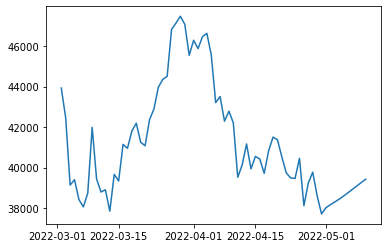

In [95]:
plt.plot(BTC_70_days)

## 4. Findings

a. What are your main findings?
b. Are your findings robust to different model specifications?

## 5. Conclusion

a. Discuss what we’ve learned from your analysis.
b. Discuss any questions that could be answered in the future.